# Vårt superprosjekt

## a

We initalize and test the functionality of Qiskit as follows

In [6]:
from qiskit import QuantumCircuit,Aer,assemble, ClassicalRegister,QuantumRegister
from qiskit.visualization import array_to_latex, plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from qiskit.algorithms.minimum_eigensolvers import VQE
from functools import partial
from scipy.optimize import minimize
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.opflow import X, Z, I
from qiskit.opflow import AerPauliExpectation
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit import transpile

optimizer = partial(minimize, method="L-BFGS-B")
simulator = Aer.get_backend('aer_simulator')

In [39]:
from qiskit.circuit import QuantumCircuit,\
                           Parameter
var_par1 = Parameter('theta1')
var_par2 = Parameter('theta2')

qc_ = QuantumCircuit(2)

qc_.ry(var_par1,0)
qc_.cry(var_par2,0,1)
qc_.draw()

┌────────────┐              
q_0: ┤ Ry(theta1) ├──────■───────
     └────────────┘┌─────┴──────┐
q_1: ──────────────┤ Ry(theta2) ├
                   └────────────┘

In [41]:
qc_par = qc_.bind_parameters({var_par1: np.pi, var_par2: np.pi/2})
qc_par.draw()

┌───────┐           
q_0: ┤ Ry(π) ├─────■─────
     └───────┘┌────┴────┐
q_1: ─────────┤ Ry(π/2) ├
              └─────────┘

In [3]:
qr = QuantumRegister(1, 'Qreg')
cr = ClassicalRegister(1, 'Creg')

qc = QuantumCircuit()
qc.add_register(qr)
qc.add_register(cr)
#qc.save_statevector()

qc.x(0)
qc.y(0)
qc.z(0)
qc.h(0)
qc.p(np.pi/2, 0)


qc.draw()

┌───┐┌───┐┌───┐┌───┐┌────────┐
  Qreg: ┤ X ├┤ Y ├┤ Z ├┤ H ├┤ P(π/2) ├
        └───┘└───┘└───┘└───┘└────────┘
Creg: 1/══════════════════════════════

Initialize a Bell state by applying Haddamard to G0 and CNOT on G1, using G0 as control gate.

In [4]:
qc_2 = QuantumCircuit()

qr_2 = QuantumRegister(2, 'qreg')
qc_2.add_register(qr_2)

cr_2 = ClassicalRegister(2, 'creg')
qc_2.add_register(cr_2)
qc_2.h(0)
qc_2.cx(0,1)
qc_2.save_statevector()
qc_2.measure(qr_2[0], cr_2[0])
qc_2.measure(qr_2[1], cr_2[1])
qc_2.draw()

┌───┐      statevector ┌─┐   
qreg_0: ┤ H ├──■────────░──────┤M├───
        └───┘┌─┴─┐      ░      └╥┘┌─┐
qreg_1: ─────┤ X ├──────░───────╫─┤M├
             └───┘      ░       ║ └╥┘
creg: 2/════════════════════════╩══╩═
                                0  1

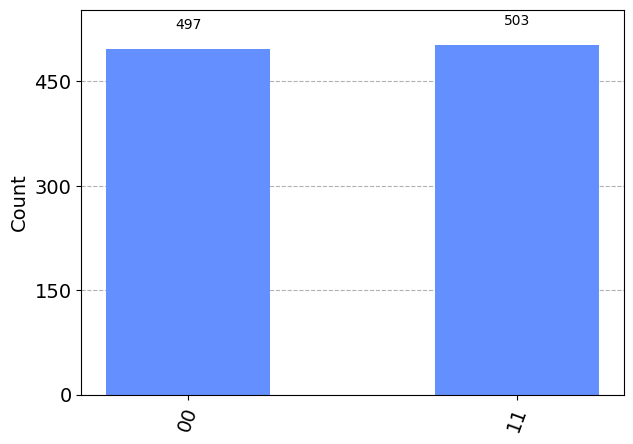

In [5]:
job = simulator.run(qc_2, shots=1000)
hist = job.result().get_counts()
plot_histogram(hist)

This is statistically in accordance with the expected Bell states.

## b


Here we initialize the Hamiltonian matrices and solve it using eigsolvers.


[[2.         0.13333333]
 [0.13333333 2.        ]]

[2.13333333 1.86666667] 

 [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


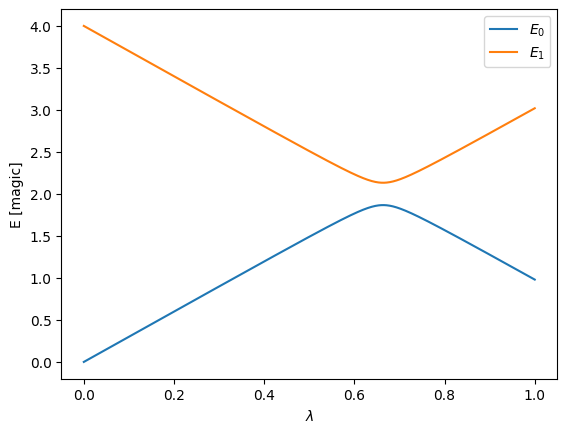

In [54]:
H0 = np.eye(2)
E1 = 0; E2 = 4
H0[0,0] = E1; H0[1,1] = E2


H1 = np.eye(2)
v11 = 3; v22 = -v11; v12 = 0.2; v21 = v12
H1[0,0] = v11; H1[0,1] = v12; H1[1,0] = v21; H1[1,1] = v22 

lmd_ = 2/3#Range [0,1]
pauli_x = np.matrix([[0,1],[1,0]])
pauli_z = np.matrix([[1,0],[0,-1]])
c = (v11 + v22)/2
omega_z = (v11-v22)/2
omega_x = v12

H_ = H0 + lmd_*H1

print(H_)
print()
eig_val, eig_vec = np.linalg.eig(H_)
print(eig_val,'\n\n', eig_vec)


n = 1000
lambdas = np.linspace(0,1,n)
Es = np.zeros((n,2))
C1s, C2s  = np.zeros_like(Es), np.zeros_like(Es)
for i, lmd_ in enumerate(lambdas):
    H_ = H0 + lmd_*H1
    eig_val, eig_vec = np.linalg.eigh(H_)
    # print(H_)
    Es[i,:] = eig_val
    C1s[i,:] = eig_vec[:,0]
    C2s[i,:] = eig_vec[:,1] 

fig, ax = plt.subplots()
ax.plot(lambdas, Es[:,0], label=r"$E_0$")
ax.plot(lambdas, Es[:,1], label=r"$E_1$")
ax.set(xlabel=r"$\lambda$", ylabel="E [magic]")
ax.legend() # Kan legge til fancy-pancy color bar for a vise "change of character" opplegget?

## c


[0.60620234 1.07872559]


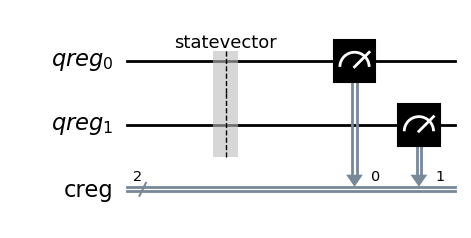

In [97]:
qc_3 = QuantumCircuit()

qr_3 = QuantumRegister(2, 'qreg')
qc_3.add_register(qr_3)

cr_3 = ClassicalRegister(2, 'creg')
qc_3.add_register(cr_3)

eta = (E1 + E2)/2
Omega = (E1-E2)/2
H0 = eta*np.eye(2) + Omega*pauli_z
are = Operator(Pauli('X'))

H1 = c * np.eye(2) + omega_z * pauli_z + omega_x * pauli_x
#I = Operator( Pauli('X') )

X_op = Operator(Pauli('X'))
Z_op = Operator(Pauli('Z'))
idty = Operator(np.eye(2))
#c_op = Operator(Multiply(0.3))

#X_op.multiply(1)
#op_ = eta*idty + Omega*Z_op + lmd_*(c*idty + omega_z*Z_op + omega_x * X_op)
#print(op_.is_unitary())
#Trenger en unitær operator for å klare å implementere det. Noen idé?

print(np.random.randn(2))


qc_3.save_statevector()
qc_3.measure(qr_3[0], cr_3[0])
qc_3.measure(qr_3[1], cr_3[1])
qc_3.draw('mpl')

## Mortenmåten

In [56]:
I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

H0 = np.kron(I,I) + np.kron(Z,I)
H1 = np.kron(I,I) + np.kron(I,Z) + np.kron(I,X) 
 
H_tot = H0 + H1

print(H_tot)

[[4. 1. 0. 0.]
 [1. 2. 0. 0.]
 [0. 0. 2. 1.]
 [0. 0. 1. 0.]]


In [58]:
c = (v11 + v22)/2
omega_z = (v11-v22)/2
omega_x = v12
eta = (E1+E2)/2
omega_ = (E1-E2)/2

HH = eta*np.kron(I,I) + omega_ * np.kron(Z,I) + c * np.kron(I,I) + omega_z * np.kron(I,Z) + omega_x * np.kron(I,X) 
val, vec = np.linalg.eig(HH)
print(val)

h1_val = c + eta
h2_val = omega_
h3_val = omega_z
h4_val = omega_x

h1 = [h1_val, [0,1] , ['I']]
h2 = [h2_val, [0] , ['Z']]
h3 = [h3_val, [1] , ['Z']]
h4 = [h4_val, [1] , ['X']]

H = [h1,h2,h3,h4]
H

[ 3.00665928 -3.00665928  7.00665928  0.99334072]


[[2.0, [0, 1], ['I']],
 [-2.0, [0], ['Z']],
 [3.0, [1], ['Z']],
 [0.2, [1], ['X']]]

In [88]:
def ansatz(theta,n_qubits):
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    param_list =[]
    for j in range(len(theta)):
        par = Parameter('theta %s' %j)
        param_list.append(par)
    #print(param_list)
    for i in range(n_qubits):
        circuit.ry(param_list[i],qreg[i])
    for i in range(n_qubits-1):
        circuit.cx(qreg[i],qreg[i+1])
    dictus ={}
    for j in range(len(theta)):
        dictus[param_list[j]] = theta[j]
    circuit = circuit.bind_parameters(dictus)
    return(circuit)

cc = ansatz([0,1], 2)
cc.draw()

┌───────┐     
q5705_0: ┤ Ry(0) ├──■──
         ├───────┤┌─┴─┐
q5705_1: ┤ Ry(1) ├┤ X ├
         └───────┘└───┘

Before ansatz


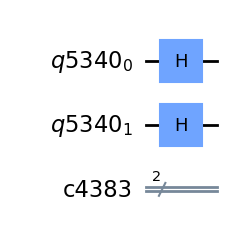

In [82]:
n_qbits = 2
theta = np.random.randn(2)

qc = QuantumCircuit()
qreg = QuantumRegister(2)
creg = ClassicalRegister(2)

qc.add_register(qreg)
qc.add_register(creg)
qc.h(qreg[:])

print('Before ansatz')
qc.draw('mpl')


[Parameter(theta 0), Parameter(theta 1)]
After ansatz


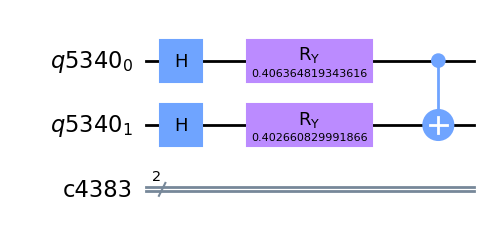

In [83]:
qc = qc.compose(ansatz(theta,n_qbits))
print('After ansatz')
qc.draw('mpl')

In [84]:
def basis_change(h_i,n_qubits):
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    ##Må nok modifisere denne  litt da den kanskje er litt for genrell
    for qubit,operator in zip(h_i[1],h_i[2]):
        if operator == 'X':
            circuit.h(qreg[qubit])
        if operator == 'Z':
            pass 
            #circuit.sdg(qreg[qubit])   ##Litt usikker på hvorfor vi bruker SDG
            #circuit.h(qreg[qubit])
    return(circuit)

[Parameter(theta 0), Parameter(theta 1)]
After basis transformation:


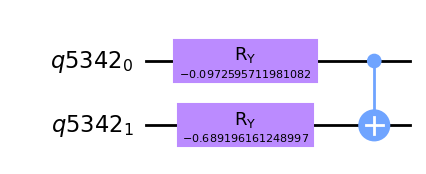

In [85]:
n_qubits = 2
theta = np.random.randn(n_qubits)

qreg = QuantumRegister(n_qubits)
qc = QuantumCircuit(qreg)
qc = qc.compose(ansatz(theta,n_qubits))
qc = qc.compose(basis_change(H[0],n_qubits))
print('After basis transformation:')
qc.draw('mpl')

In [89]:
def get_energy(theta):
    n_qubits = 2
    qreg = QuantumRegister(n_qubits)
    qc = QuantumCircuit(qreg)
    qc = qc.compose(ansatz(theta,n_qubits))
    qc_list = []
    for idx,h_i in enumerate(H):
        basis_change_circuit = basis_change(h_i,n_qubits)
        new_qc = qc.compose(basis_change_circuit)
        creg = ClassicalRegister(len(h_i[1]))
        new_qc.add_register(creg)
        new_qc.measure(qreg[h_i[1]],creg)
        qc_list.append(new_qc)
        
    shots = 10000
    job = simulator.run(qc_list,shots=shots)
    E = np.zeros(len(qc_list))
    for i in range(len(E)):
        result = job.result()
        counts = result.get_counts(i)
        for key,value in counts.items():
            e = 1
            for bit in key:
                if bit == '0':
                    e *= 1
                if bit == '1':
                    e *= -1
            E[i] += e*value
        E[i] *= H[i][0]
    E /= shots
    return(np.sum(E))

theta = np.random.randn(2)

get_energy(theta)

2.2596000000000003

In [90]:
theta = np.random.randn(2)
res = minimize(get_energy, theta, method='Powell',tol=1e-12)
get_energy(res.x)

0.9901200000000003

In [93]:
epochs = 200
theta = np.random.randn(2)
for epoch in range(epochs):
    print(epoch,get_energy(theta))
    grad = np.zeros_like(theta)
    for idx in range(theta.shape[0]):
        theta_temp = theta.copy()
        theta_temp[idx] += np.pi/2
        E_plus = get_energy(theta_temp)
        theta_temp[idx] -= np.pi
        E_minus = get_energy(theta_temp)
        grad[idx] = (E_plus - E_minus)/2
    theta -= 0.1*grad

0 2.7312800000000004
1 2.5304800000000003
2 2.0851599999999997
3 1.2758
4 -0.1583999999999999
5 -2.09856
6 -4.3273600000000005
7 -5.93616
8 -6.6774000000000004
9 -6.900440000000001
10 -6.97704
11 -6.99568
12 -6.999
13 -7.002680000000001
14 -7.005440000000001
15 -7.00812
16 -7.0052
17 -7.004359999999999
18 -7.00336
19 -7.00344
20 -7.0032
21 -7.00508
22 -7.0036000000000005
23 -7.004160000000001
24 -7.00412
25 -7.00844
26 -6.99956
27 -7.001519999999999
28 -7.00844
29 -7.00244
30 -7.001040000000001
31 -7.004440000000001
32 -7.00368
33 -7.003640000000001
34 -7.00052
35 -7.00312
36 -7.004160000000001
37 -7.003800000000001
38 -7.00404
39 -7.00952
40 -7.00236
41 -7.00184
42 -7.0068
43 -7.002960000000001
44 -7.002800000000001
45 -7.003360000000001
46 -7.00436
47 -7.0040000000000004
48 -7.002
49 -6.99972
50 -7.001119999999999
51 -7.00408
52 -7.0041199999999995
53 -7.00372
54 -7.00104
55 -7.01124
56 -7.007879999999999
57 -7.006000000000001
58 -7.007359999999999
59 -7.0056
60 -7.000520000000001
61

In [9]:
#1d
#Skal gjennomføres som funksjon av lambda, tar det siden
lmd_ = 0.8
s_00 = np.array([1,0,0,0])
s_10 = np.array([0,1,0,0])
s_01 = np.array([0,0,1,0])
s_11 = np.array([0,0,0,1])
#Kan eventuelt bruke np.kron( [1,0], [0,1])
        
eps_list = [0,2.5,6.5,7]
H0 = np.eye(4)
H0[0,0] = eps_list[0];H0[1,1] = eps_list[1];H0[2,2] = eps_list[2];H0[3,3] = eps_list[3]

pauli_x = np.matrix([[0,1],[1,0]])
pauli_z = np.matrix([[1,0],[0,-1]])
H_x = 2.0
H_z = 3.0
H_I = H_x * np.kron(pauli_x, pauli_x) + H_z * np.kron(pauli_z, pauli_z)

H_tot = H0 + lmd_*H_I
#print(H_tot)

eig_vals, eig_vecs = np.linalg.eig(H_tot)
#print(eig_vals) 
#print()
#print(eig_vecs)

#Computing partial density matrix
rho_a = (eig_vecs[0].max() + eig_vecs[1].max()) * np.outer(s_00,s_00) + (eig_vecs[2].max() + eig_vecs[3].max()) * np.outer(s_11,s_11)
rho_b = (eig_vecs[0].max() + eig_vecs[2].max()) * np.outer(s_00,s_00) + (eig_vecs[1].max() + eig_vecs[3].max()) * np.outer(s_11,s_11)

#Compute entropy
S_a = - np.trace(rho_a)*np.log2(np.trace(rho_a))
S_b = - np.trace(rho_b)*np.log2(np.trace(rho_b))
S_a, S_b

(-3.207020335903938, -3.207020335903938)

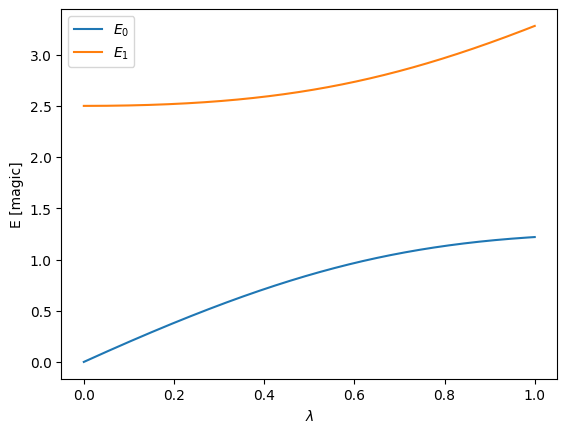

In [20]:
n = 1000
lambdas = np.linspace(0,1,n)
Es = np.zeros((n,4))
C1s, C2s  = np.zeros_like(Es), np.zeros_like(Es)

for i, lmd_ in enumerate(lambdas):
    H_ = H0 + lmd_*H1
    eig_val, eig_vec = np.linalg.eigh(H_)
    #print(eig_val)
    #print(eig_vec.shape)
    Es[i,:] = eig_val
    #C1s[i,:] = eig_vec[:,0]
    #C2s[i,:] = eig_vec[:,1] 

fig, ax = plt.subplots()
ax.plot(lambdas, Es[:,0], label=r"$E_0$")
ax.plot(lambdas, Es[:,1], label=r"$E_1$")
ax.set(xlabel=r"$\lambda$", ylabel="E [magic]")
ax.legend() # Kan legge til fancy-pancy color bar for a vise "change of character" opplegget?

The entropy is as expected, similar, as there are no difference in the configuration of the two states. As such, there should be an equal amount of entanglement entropy. The energies follow the same asymptotic convergence, which indeed confirms their entanglement.

## Stian-måten


In [21]:
#import numpy as np
#import qiskit as qk
from scipy.optimize import minimize
simulator = qk.Aer.get_backend('qasm_simulator') 

In [22]:
n_qubits = 2
n_cbits = 2
qreg = qk.QuantumRegister(n_qubits)
creg = qk.ClassicalRegister(n_cbits)
circuit = qk.QuantumCircuit(qreg,creg)

In [23]:
I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
hx = 2; hz = 3; eps_list = [0,2.5,6.5,7]

H_0 = np.matrix([[eps_list[0],0,0,0],[0,eps_list[1],0,0],[0,0,eps_list[2],0],[0,0,0,eps_list[3]]])
H_I = hx * np.kron(X,X) + hz* np.kron(Z,Z) 
H = H_0 + H_I
eigvals,eigvecs = np.linalg.eigh(H)
print(eigvals)
print(eigvecs)

c_1 = 1
c_2 = 1
c_3 = 1

h_1 = [c_1,[0],['z,z']]
h_2 = [c_2,[1],['x,x']]
H = [h_1,h_2]

[-1.32842712  2.46887113  4.32842712 10.53112887]
[[-0.         -0.96649965  0.         -0.25666794]
 [ 0.92387953  0.         -0.38268343  0.        ]
 [-0.38268343  0.         -0.92387953  0.        ]
 [ 0.          0.25666794  0.         -0.96649965]]


In [ ]:
def ansatz(theta,n_qubits):
    qreg = qk.QuantumRegister(n_qubits)
    circuit = qk.QuantumCircuit(qreg)
    for i in range(n_qubits):
        circuit.ry(theta[i],qreg[i])
    for i in range(n_qubits-1):
        circuit.cx(qreg[i],qreg[i+1])
    return(circuit)

In [94]:


qreg = qk.QuantumRegister(n_qubits)
circuit = qk.QuantumCircuit(qreg)
circuit.h(qreg[:2])
print('Before ansatz')
print(circuit.draw())
theta = np.random.randn(2)
n_qubits = 2
circuit = circuit.compose(ansatz(theta,n_qubits))
print('After ansatz')
print(circuit.draw())

Before ansatz
          ┌───┐
q13396_0: ┤ H ├
          ├───┤
q13396_1: ┤ H ├
          └───┘
After ansatz
          ┌───┐┌────────────────────────┐     
q13396_0: ┤ H ├┤ Ry(-0.341078715301854) ├──■──
          ├───┤├────────────────────────┤┌─┴─┐
q13396_1: ┤ H ├┤ Ry(-0.849577554217697) ├┤ X ├
          └───┘└────────────────────────┘└───┘


In [95]:
def basis_change(h_i,n_qubits):
    qreg = qk.QuantumRegister(n_qubits)
    circuit = qk.QuantumCircuit(qreg)
    
    for qubit,operator in zip(h_i[1],h_i[2]):
        if operator == 'x':
            circuit.h(qreg[qubit])
        if operator == 'z':
            circuit.sdg(qreg[qubit])
            circuit.h(qreg[qubit])
    return(circuit)
n_qubits = 2
qreg = qk.QuantumRegister(n_qubits)
circuit = qk.QuantumCircuit(qreg)
theta = np.random.randn(n_qubits)
circuit = circuit.compose(ansatz(theta,n_qubits))
print('Ansatz circuit')
print(circuit.draw())
circuit = circuit.compose(basis_change(H[1],n_qubits))
print('After basis transformation:')
print(circuit.draw())

Ansatz circuit
          ┌────────────────────────┐     
q13398_0: ┤ Ry(-0.548523047599605) ├──■──
          ├───────────────────────┬┘┌─┴─┐
q13398_1: ┤ Ry(-1.21501907978202) ├─┤ X ├
          └───────────────────────┘ └───┘
After basis transformation:
          ┌────────────────────────┐     
q13398_0: ┤ Ry(-0.548523047599605) ├──■──
          ├───────────────────────┬┘┌─┴─┐
q13398_1: ┤ Ry(-1.21501907978202) ├─┤ X ├
          └───────────────────────┘ └───┘


In [96]:
def get_energy(theta):
    n_qubits = 2
    qreg = qk.QuantumRegister(n_qubits)
    circuit = qk.QuantumCircuit(qreg)
    circuit = circuit.compose(ansatz(theta,n_qubits))
    circuit_list = []
    for idx,h_i in enumerate(H):
        basis_change_circuit = basis_change(h_i,n_qubits)
        new_circuit = circuit.compose(basis_change_circuit)
        creg = qk.ClassicalRegister(len(h_i[1]))
        new_circuit.add_register(creg)
        new_circuit.measure(qreg[h_i[1]],creg)
        circuit_list.append(new_circuit)
    shots = 10000
    job = simulator.run(circuit_list,shots=shots)
    E = np.zeros(len(circuit_list))
    for i in range(len(circuit_list)):
        result = job.result()
        counts = result.get_counts(i)
        for key,value in counts.items():
            e = 1
            for bit in key:
                if bit == '0':
                    e *= 1
                if bit == '1':
                    e *= -1
            E[i] += e*value
        E[i] *= H[i][0]
    E /= shots
    return(np.sum(E))

theta = np.random.randn(2)
get_energy(theta)

2.83168

In [97]:
#Minimize the data
theta = np.random.randn(2)
res = minimize(get_energy, theta, method='Powell',tol=1e-12)
get_energy(res.x)

-7.2

In [99]:
##Gradient descent
epochs = 200
theta = np.random.randn(2)
for epoch in range(epochs):
    print(epoch,get_energy(theta))
    grad = np.zeros_like(theta)
    for idx in range(theta.shape[0]):
        theta_temp = theta.copy()
        theta_temp[idx] += np.pi/2
        E_plus = get_energy(theta_temp)
        theta_temp[idx] -= np.pi
        E_minus = get_energy(theta_temp)
        grad[idx] = (E_plus - E_minus)/2
    theta -= 0.1*grad

0 2.8587599999999997
1 2.5185999999999997
2 1.74168
3 0.23412000000000022
4 -2.06448
5 -4.63068
6 -6.2926400000000005
7 -6.95284
8 -7.1316
9 -7.18796
10 -7.19696
11 -7.19956
12 -7.2
13 -7.2
14 -7.19956
15 -7.1994
16 -7.1994
17 -7.2
18 -7.2
19 -7.2
20 -7.2
21 -7.2
22 -7.2
23 -7.2
24 -7.2
25 -7.2
26 -7.2
27 -7.1994
28 -7.2
29 -7.2
30 -7.2
31 -7.2
32 -7.2
33 -7.2
34 -7.2
35 -7.2
36 -7.2
37 -7.19996
38 -7.2
39 -7.2
40 -7.2
41 -7.2
42 -7.2
43 -7.2
44 -7.2
45 -7.2
46 -7.2
47 -7.2
48 -7.19996
49 -7.2
50 -7.2
51 -7.19996
52 -7.2
53 -7.2
54 -7.2
55 -7.2
56 -7.2
57 -7.2
58 -7.2
59 -7.2
60 -7.2
61 -7.2
62 -7.2
63 -7.1994
64 -7.2
65 -7.2
66 -7.2
67 -7.2
68 -7.2
69 -7.2
70 -7.2
71 -7.2
72 -7.2
73 -7.2
74 -7.2
75 -7.2
76 -7.2
77 -7.2
78 -7.2
79 -7.2
80 -7.2
81 -7.2
82 -7.2
83 -7.2
84 -7.2
85 -7.2
86 -7.2
87 -7.2
88 -7.2
89 -7.2
90 -7.1994
91 -7.2
92 -7.2
93 -7.2
94 -7.1994
95 -7.2
96 -7.19996
97 -7.2
98 -7.2
99 -7.2
100 -7.2
101 -7.2
102 -7.2
103 -7.2
104 -7.2
105 -7.2
106 -7.2
107 -7.2
108 -7.2
109

## 1f)

In [100]:
v = 10
I = np.eye(2)
H_4 = -(np.kron(pauli_z,I) + np.kron(I, pauli_z)) - np.sqrt(6)/2 * v *(np.kron(pauli_x, I) + 
                                                                       np.kron(I, pauli_x) + 
                                                                       np.kron(pauli_x, pauli_z) - 
                                                                       np.kron(pauli_z, pauli_x))
H_4_o = - pauli_z - 3*v*pauli_x


eigval_even, eigvec_even = np.linalg.eig(H_4)
eigval_odd, eigvec_odd = np.linalg.eig(H_4_o)

print(eigval_even)
print(eigval_odd)

H_op = Operator(H_4)


[-3.46987031e+01  9.09862463e-16  3.46987031e+01 -0.00000000e+00]
[-30.01666204  30.01666204]


Disse verdiene stemmer på en såkalt prikk med analytiske verdier. Det er jo ganske lovende. Det er mulig her å lage noen fancy plot der vi varierer på v, eller tilnærmer Hartree-Fock?

Det er ganske snodig dette med VQE, men prøver bare:

In [101]:
h1_lip = [-1, [0,1], ['z']]
h2_lip = [-np.sqrt(6)/2*v, [0], ['x']]
h3_lip = [-np.sqrt(6)/2*v, [1], ['x']]
h4_lip = [-np.sqrt(6)/2*v, [0,1], ['xz']]
h5_lip = [np.sqrt(6)/2*v, [0,1], ['zx']]
H_4_lip = [h1_lip, h2_lip, h3_lip, h4_lip, h5_lip]

In [170]:
import qiskit as qk
def ansatz(theta,n_qubits):
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    #print(theta)
    param_list =[]
    for j in range(len(theta)):
        par = Parameter('theta %s' %j)
        param_list.append(par)
    
    for i in range(n_qubits):
        circuit.ry(param_list[i-1],qreg[i])
    for i in range(n_qubits-1):
        circuit.cry(param_list[i],qreg[i],qreg[i+1])
    #print(param_list)    
    dictus ={}
    for j in range(len(theta)):
        dictus[param_list[j]] = theta[j]
    circuit = circuit.bind_parameters(dictus)
    circuit = transpile(circuit, backend = simulator)
    return(circuit)

def basis_change(h_i , n_qubits):
    qreg = qk.QuantumRegister(n_qubits)
    circuit = qk.QuantumCircuit(qreg)
    circuit = circuit.compose(ansatz(theta,n_qubits))

    for qubit,operator in zip(h_i[1],h_i[2]):
        #if operator == 'z':
            #circuit.z(qreg[qubit])
            #circuit.z(qreg[qubit+1])
        if operator == 'x':
            if qubit == 1:
                circuit.h(qreg[qubit])#, qreg[qubit-1])
            if qubit == 0:
                circuit.h(qreg[qubit])#, qreg[qubit+1])
        if operator == 'xz':
            #circuit.z(qreg[qubit+1])
            circuit.h(qreg[qubit])
        if operator == 'zx':
            #circuit.z(qreg[qubit])
            circuit.h(qreg[qubit+1])
    return(circuit)

def get_energy(theta, n_qubits=2):
    #theta1 = qk.circuit.Parameter('theta')
    qreg = qk.QuantumRegister(n_qubits)
    circuit = qk.QuantumCircuit(qreg)
    circuit_list = []
    for idx,h_i in enumerate(H_4_lip):
        basis_change_circuit = basis_change(h_i,n_qubits)
        new_circuit = circuit.compose(basis_change_circuit)
        creg = qk.ClassicalRegister(len(h_i[1]))
        new_circuit.add_register(creg)
        new_circuit.measure(qreg[h_i[1]],creg)
        #print(new_circuit.draw())

        circuit_list.append(new_circuit)
    shots = 10000
    job = simulator.run(circuit_list,shots=shots)
    E = np.zeros(len(circuit_list))
    for i in range(len(circuit_list)):
        result = job.result()
        counts = result.get_counts(i)
        for key,value in counts.items():
            e = 1
            for bit in key:
                if bit == '0':
                    e *= 1
                if bit == '1':
                    e *= -1
            E[i] += e*value
        E[i] *= H_4_lip[i][0]
    E /= shots
    return(np.sum(E))



minval = 0 
for i in range(10000):
    theta= np.random.randn(2)
    a = get_energy(theta)
    if a<minval:
        print(a, theta)
        minval=a
#print(a)

-16.82826035089416 [-0.276431   1.5419098]
-30.02549526182895 [0.24590444 1.8847525 ]
-31.935086045955554 [0.58170497 1.6373698 ]
-32.99385336866469 [0.72240017 2.02960939]
-32.994816630145074 [0.49236297 1.86234466]
-33.34084213259141 [0.50508568 1.91340877]
-33.53565692484345 [0.65597264 2.17857645]
-33.89114008114805 [0.61775106 2.06065331]


Har her en beste på -33.91

In [132]:
n_qubits = 2
theta = np.random.randn(2)
res = minimize(get_energy, theta, method='Powell',tol=1e-12)
get_energy(res.x)

-19.475647032134034

Egenverdier skal være $\big[0, \pm 30.01,\pm 34.69 \big]$ for v = 10, der 30 er for 2x2 matrisen.

Det er forskjell i hvilke forventningsverdier jeg får her og i det analytiske. Tror vi at det er fordi rotasjonsgatene påvirker det endelige resultatet, eller er det fordi jeg har implementert gates feil? Tar veldig gjerne input.

In [130]:
##Gradient descent
epochs = 200
theta = np.random.randn(2)
for epoch in range(epochs):
    print(epoch,get_energy(theta,2))
    grad = np.zeros_like(theta)
    
    for idx in range(theta.shape[0]):
        theta_temp = theta.copy()
        theta_temp[idx] += np.pi/20
        E_plus = get_energy(theta_temp)
        theta_temp[idx] -= np.pi/10
        E_minus = get_energy(theta_temp)
        grad[idx] = (E_plus - E_minus)/2
    theta -= 0.1*grad

0 3.236527470573731
1 3.618245829419041
2 3.3187565500278415
3 3.6110973601906915
4 3.6766789909308852
5 3.5738045037917257
6 3.5198662397077136


KeyboardInterrupt: 

In [84]:

#from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
#converts chi to V
def Vp(E,omega,chi):
    return (chi*E)/(omega-1)
epsilon = 1
omega = 2
chi5 = np.arange(0,2.1,0.1)
adam =qk.algorithms.optimizers.ADAM(maxiter=10000)
LM_sim = []

for x in chi5:
    v = Vp(epsilon,omega,x)
    H = 0.5 * epsilon * np.kron(Z,I) +0.5 * epsilon * np.kron(I,Z)-0.5 * v * np.kron(X,X) + 0.5 * v * np.kron(Y,Y)
    vec = Aer.get_backend('statevector_simulator')
    vqe = VQE(ansatz=ansatz([0.1,0.2],2),optimizer=adam, estimator=Estimator)
    result = vqe.compute_minimum_eigenvalue(H)
    LM_sim.append(result.eigenvalue)


plt.plot(chi,np.array(exact),label='$E_{exact}$',color='b')
plt.plot(chi,np.array(HF),label='$E_{HF}$',color='g')
plt.scatter(chi5,LM_sim,label='QC state vec',color='cyan')
plt.axvline(1, color = 'k', linestyle='--')
plt.ylabel('$E_{g.s}$')
plt.xlabel('$\chi$')
plt.title('$\Omega=2$')
plt.legend()

AttributeError: 'numpy.ndarray' object has no attribute 'num_qubits'